# Importing packages and data

In [ ]:
# install dependencies
!pip install -q condacolab
import condacolab
condacolab.install()
import condacolab
#condacolab.check()


#condacolab.check()
! conda config --add channels conda-forge
! conda config --add channels ostrokach-forge
! conda config --add channels pkgw-forge
! conda install gtk3
! conda install pygobject graph-tool cairo
! conda install -c conda-forge graph-tool
! git clone https://github.com/martingerlach/hSBM_Topicmodel.git

In [28]:
import json
import pandas as pd
import numpy as np

#Importing modules for preprocessing 
import nltk
nltk.download('punkt')
from nltk import word_tokenize
import nltk
import string 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
import string
import re
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
from google.colab import files


# # Importing modules for HSBM
import graph_tool.all as gt
from hSBM_Topicmodel.sbmtm import sbmtm
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# We mount drive
from google.colab import drive
drive.mount('/content/drive/') # this triggers permission prompts

Mounted at /content/drive/


In [3]:
  #Importing data 
import os
path = '/content/drive/My Drive/HSBM/'
#change directory and setting path to drive 
os.chdir(path)

In [4]:
# We load dictionary with names of researchers as
# keys and wikipedia-text files as values 
# All researchers' names have been filtered from the text 
with open('wiki_dict_noname.json', 'r') as f:
    text_dict = json.load(f)

In [5]:
# We load dictionary with name as keys and field and community as keys. 
# This is only for researchers in  the identified giant component.  
with open('name_field_community.json', 'r') as f:
    discipline_dict = json.load(f)

# Preprocessing  

In [6]:
#Defining a fucntion for preprocessing including removal of stopwords and punctuation,  lemmatising, and tokenizing.  

def preprocess(text, remove_stopwords=True):

    # import stopwords
    stop_words_list = stopwords.words("english")

     # 1) Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 2) Remove words with 2 or less characters
    text=re.sub(r'\b\w{1,2}\b','',text)

    if remove_stopwords:
        # 3) Remove stopwords and tokenize
        tokens = [token for token in nltk.word_tokenize(text.lower()) if token not in stop_words_list]
    else:
        # 3) Tokenize
        tokens = [token for token in nltk.word_tokenize(text.lower())]

    # 4) Lemmatize = convert words to their root (running -> run)
    wnl = nltk.WordNetLemmatizer() 
    lemmas = [wnl.lemmatize(t) for t in tokens] 
    return lemmas # return a list of lemmas

In [9]:
# We subset the text dictionary to entail researchers in the giant component 
text_dict=dict((k, text_dict[k]) for k in (discipline_dict.keys()))

# We add text as key to the dictionary that also contains scientific field and community. 
for names,text in zip(discipline_dict.items(),text_dict.values()):
  discipline_dict[names[0]]['text']=preprocess(text)

# We sort dictionary by field such that all antropologists are first, then economists,those in multiple fields, political scientists, psychologists,sociologists 
discipline_dict=dict(sorted(discipline_dict.items(), key=lambda item: item[1]['field']))

Removing infrequent words 

In [8]:
#Defining cutoff for how many times words must occur
cutoff=5
c=Counter()
for doc in tqdm(discipline_dict.values()):
  c.update(Counter(doc['text']))
vocab=c.most_common(25000)
vocab=set([word for word, count in vocab if count >cutoff])

docs=[]
for value in discipline_dict.values():
  doc=[word for word in value['text'] if word in vocab]
  docs.append(doc)

  0%|          | 0/2100 [00:00<?, ?it/s]

# Running model to find topics

In [11]:
# We define the HSBM-model
model=sbmtm()
# We make graph of documents 
model.make_graph(docs,documents=['%d'%i for i in tqdm(range(len(docs)))])

  0%|          | 0/2100 [00:00<?, ?it/s]

In [ ]:
# We set a seed to be able to reproduce the results 
gt.seed_rng(25)
model.fit()

<NestedBlockState object, with base <BlockState object with 22167 blocks (871 nonempty), degree-corrected, for graph <Graph object, undirected, with 22453 vertices and 979261 edges, 2 internal vertex properties, 1 internal edge property, at 0x7fe57816c110>, at 0x7fe5780cfd50>, and 6 levels of sizes [(22453, 871), (871, 83), (83, 13), (13, 3), (3, 2), (2, 1)] at 0x7fe5783a6b50>


In [ ]:
import pickle
# We save the model
filename = 'final_HSBM_28_11.sav'
pickle.dump(model, open(filename, 'wb'))

**Identifying all topics** 

The SBM has a hierarchical structure which implies that topics at the lowest levels contain more granular information about the content of the documents, whereas, topics at higher levels are clusters of the lower level topics and, thus, more aggregate (ref). 

The hSBM generates 416 topics at Level 0, 48 topics at Level 1, 7 topics at Level 2, and 2 topics at Level 3. We choose to work with topics at level 2 which we deem to be the most appropriate level to examine as the topics appear to be reasonably coherent and manageable to manually select from. A list of topics at all levels is attached in Appendix X.

**Choosing relevant topics** 

For each of the generated topics, we examine the 10 most probable words in order to select a subset of topics which we assess to be the most interesting to further examine. We draw on a heuristic approach which implies that we select topics that we assess to be semantically coherent and exclusive. Furthermore, we only select topics that we assess to be related to the content of the theoretical contributions of the researchers and we discard topics that appear to be related to academic prestige, timely relevans (topics consisting only of years), and nationality (topics consisting of city names and words in non-English languages). We select a subset of 21 topics which we give appropriate descriptive names. 


In [12]:
import pickle
filename = 'final_HSBM_28_11.sav'
model = pickle.load(open(filename, 'rb'))

In [13]:
for i in range(5):
  topics=len(list(model.topics(l=i,n=10)))
  print('\n','At Level {} the number of topics is {}'.format(i,topics))

/content/hSBM_Topicmodel/sbmtm.py:545: RuntimeWarning: invalid value encountered in true_divide
  p_td_d = (n_db/np.sum(n_db,axis=1)[:,np.newaxis]).T
/content/hSBM_Topicmodel/sbmtm.py:551: RuntimeWarning: invalid value encountered in true_divide
  p_tw_d = (n_dbw/np.sum(n_dbw,axis=1)[:,np.newaxis]).T



 At Level 0 the number of topics is 416

 At Level 1 the number of topics is 48

 At Level 2 the number of topics is 7

 At Level 3 the number of topics is 2

 At Level 4 the number of topics is 1


Printing the topics of the HSBM

In [ ]:
#We print the topics
# l is the level which we want the topics on. Level 0 is most fundamental. Level 1 is more aggregated. 
# n is the largest topic loading words we want to see.  
model.topics(l=1,n=10)

/content/drive/My Drive/HSBM/hSBM_Topicmodel/sbmtm.py:545: RuntimeWarning: invalid value encountered in true_divide
  p_td_d = (n_db/np.sum(n_db,axis=1)[:,np.newaxis]).T
/content/drive/My Drive/HSBM/hSBM_Topicmodel/sbmtm.py:551: RuntimeWarning: invalid value encountered in true_divide
  p_tw_d = (n_dbw/np.sum(n_dbw,axis=1)[:,np.newaxis]).T


{0: [('london', 0.19814028956565152),
  ('cambridge', 0.15582875686470293),
  ('oxford', 0.11857214178731902),
  ('vol', 0.08980279580629057),
  ('ed', 0.07220419370943584),
  ('macmillan', 0.029331003494757864),
  ('equality', 0.021342985521717425),
  ('palgrave', 0.015664003994008985),
  ('australia', 0.01510234648027958),
  ('lse', 0.014603095356964553)],
 1: [('association', 0.07794005064483835),
  ('chicago', 0.06851775513809552),
  ('harvard', 0.061657146222248396),
  ('relation', 0.05588599022436841),
  ('organization', 0.04293033390259702),
  ('california', 0.039308639067192744),
  ('2002', 0.03777751604734703),
  ('princeton', 0.03548083151757847),
  ('columbia', 0.03294858960014133),
  ('washington', 0.029032448030151346)],
 2: [('work', 0.05826812697322047),
  ('also', 0.047232900730350726),
  ('one', 0.0396095318765808),
  ('year', 0.031512293940991455),
  ('became', 0.020826546145963524),
  ('later', 0.020370447154712333),
  ('many', 0.01804848865379717),
  ('well', 0.0132

7: Anthropology  <br>
10: Human nature  <br>
12: Foreign politics  <br>
14: Trade and capitalism  <br>
15: Science studies <br>
16: Cultural sociology <br>
17: Race <br>
19: War politics <br>
20: Measuring behavior  <br>
25: Mentality and personality  <br>
26: Conflict studies  <br>
27: Child/mother relations  <br>
28: Governing publics  <br>
37: Economics  <br>
38: Language studies  <br>
39: Religious stories  <br>
40: Market mechanisms  <br>
41: Philosophy  <br>
43: Power and classes  <br>
44: Cognitive psychology  <br>
46: Democratic policymaking  <br>

**Plotting result**

We plot the word-document network as inferred by the stochastic block model:

- document-nodes are on the left
- word-nodes are on the right
- different colors correspond to the different groups

The result is a grouping of nodes into groups on multiple levels in the hierarchy:

on the uppermost level, each node belongs to the same group (square in the middle). On the next-lower level, we split the network into two groups: the word-nodes and the document-nodes (blue sqaures to the left and right, respectively). Only next lower levels constitute a non-trivial structure: We now further divide nodes into smaller groups (document-nodes into document-groups on the left and word-nodes into word-groups on the right)

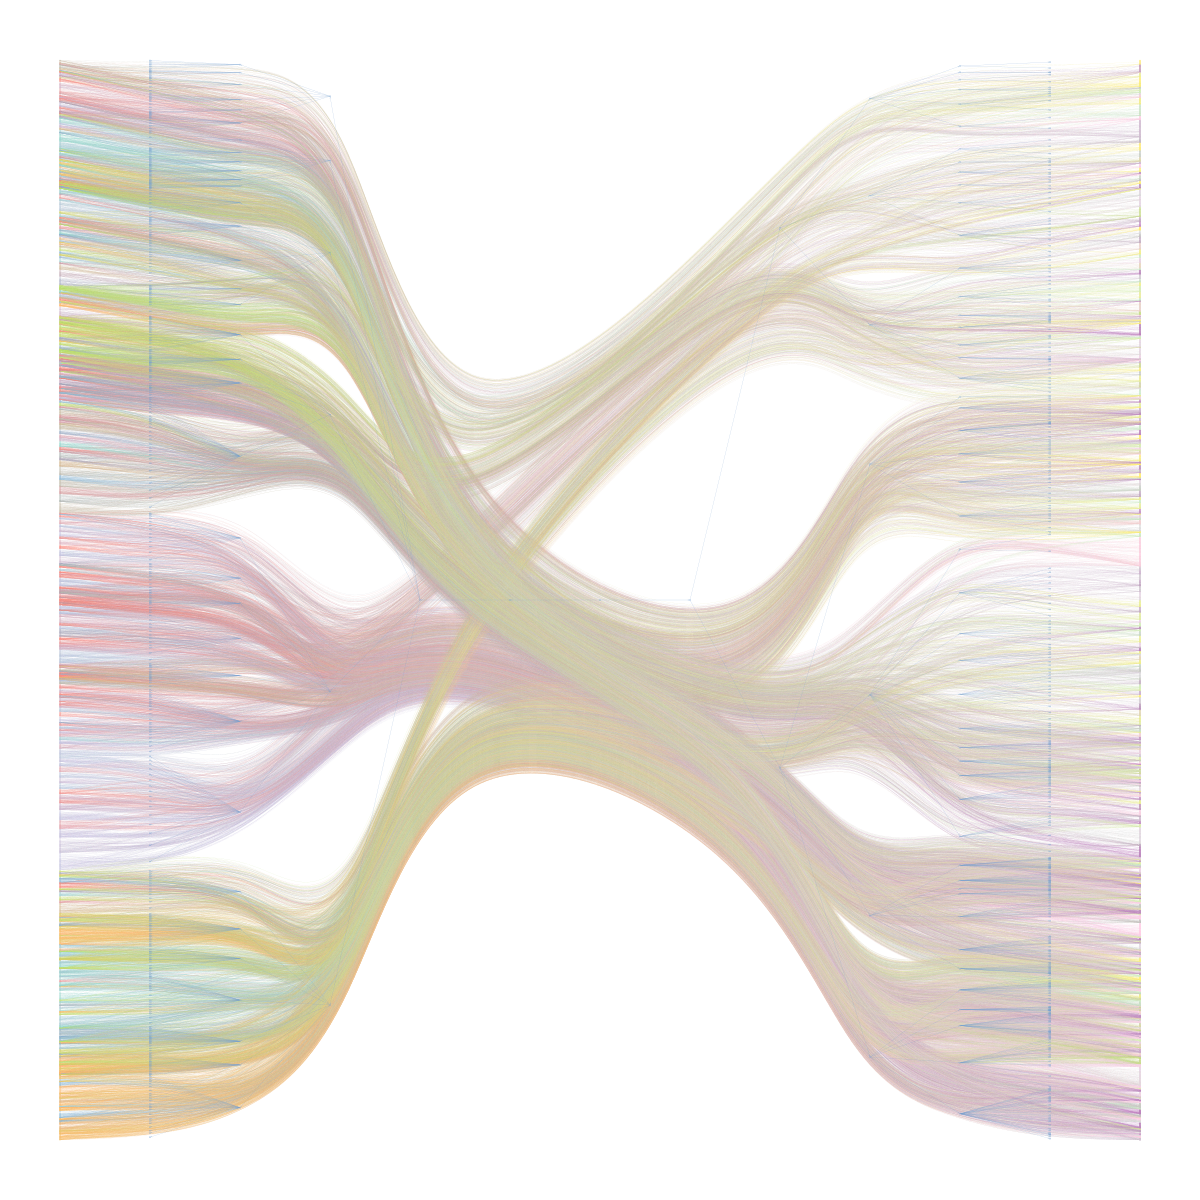

In [36]:
# Plotting the HSBM
model.plot(filename='hSBM_Topicmodel.png',nedges=20000)
files.download("hSBM_Topicmodel.png")

# Preparing topics data for further analysis

We make a dataframe of most probable words for each topic

In [15]:
# We make the identified topics to a dictionary
dict_topics=model.topics(l=1,n=10)

# We convert the dictionary to a dataframe with the most probable words for each topic 
for i in range(len(dict_topics)):
  if i==0:
    v=np.hstack((i*np.ones((len(dict_topics[i]),1)).astype(int),np.array(dict_topics[i])))
    continue
  h=np.hstack((i*np.ones((len(dict_topics[i]),1)).astype(int),np.array(dict_topics[i])))
  v=np.vstack((v,h))
topic_df=pd.DataFrame(v)  

topic_df=topic_df.rename(columns={0:'Topic',1:'Topic_words',2:'Probability_of_word_in_topic'})

# Saving the topic df as csv
from google.colab import files
topic_df.to_csv('HSBM_topics_28.11.csv')
files.download('HSBM_topics_28.11.csv')

We make a dataframe with the probability that a document belongs to a topic. 

We find the parameters of the of the model as numpy arrays. 

In [21]:
# We make a dictionary of the parameter types. There are 6 keys in total. 
# We are interested in p_tw_d which is an array of probabilities of a given document (wikipedia text in our case)
# that belong to each topic. 
model_params=model.get_groups(l=1)
print(model_params.keys())

# The shape corresponds to the number of topics and documents
print(model_params['p_tw_d'].shape)

dict_keys(['Bd', 'Bw', 'p_tw_w', 'p_td_d', 'p_w_tw', 'p_tw_d', 'label_map'])
(48, 2100)


/content/hSBM_Topicmodel/sbmtm.py:545: RuntimeWarning: invalid value encountered in true_divide
  p_td_d = (n_db/np.sum(n_db,axis=1)[:,np.newaxis]).T
/content/hSBM_Topicmodel/sbmtm.py:551: RuntimeWarning: invalid value encountered in true_divide
  p_tw_d = (n_dbw/np.sum(n_dbw,axis=1)[:,np.newaxis]).T


In [22]:
#Creating a DF with document probabilities 
doc_prob=pd.DataFrame(model_params['p_tw_d'])
print(doc_prob.shape)

# Transposing DF to have documents as rows and probabilities as columns
doc_prob=doc_prob.transpose()
print(doc_prob.shape)

(48, 2100)
(2100, 48)


In [23]:
# We create lists of disciplines, names, and the previously identified communities 
discipline=[]
community=[]
names=[]
text_list=[]
for key,val in discipline_dict.items():
  names.append(key)
  community.append(val['community'])
  discipline.append(val['field'])
  text_list.append(val['text'])

researcher_attributes = pd.DataFrame(
    {'name': names,
     'discipline':discipline,
     'community':community,
     'text':text_list})

hsbm_probs=pd.concat([researcher_attributes,doc_prob],axis=1)

hsbm_probs.to_csv('HSBM_probs_28.11.csv')
files.download('HSBM_probs_28.11.csv')